# Deep Convolutional GAN

The vanilla GAN we have seen does not take into account the class of an image; thus, while it can produce realistic images that look like images from the training set, it cannot produce images of a specific, desired class, such as only images of cats. We can extend the vanilla GAN by incorporating extra conditioning information, for example to specify which class we want it to generate. To do this, we pass a conditioning vector $c$ to both the generator and discriminator, so they become $G(z, c)$ and $D(x, c)$, respectively. Then the generator $G$ can take into account which class it is supposed to generate, and $D$ can score how realistic a generated image is, given that it is intended to represent a specific class.

Then, the objective function of the discriminator becomes:
$$
J_D = \mathbb{E}_{x \sim p_{data}} [ - \log D(x, c) ] + \mathbb{E}_{z \sim q(z)} [ - \log(1 - D(G(z, c), c)) ]
$$

And the objective function of the generator becomes:
$$
J_G = \mathbb{E}_{z \sim q(z)} [ - \log D(G(z, c), c) ]
$$

In [1]:
import os
import math
import random
import itertools

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

from IPython import display

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dataroot = 'data'
workers = 2
batchSize = 64
imageSize = 64
nz = 100
ngf = 64
ndf = 64
nepochs = 40
lr = 0.0002
beta1 = 0.5

In [3]:
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)

('Random Seed: ', 5567)


In [4]:
dataset = dset.CIFAR10(root=dataroot, download=True,
                       transform=transforms.Compose([
                           transforms.Scale(imageSize),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=workers)

In [5]:
nc = 3

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.LeakyReLU(0.2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1)

In [6]:
G = Generator()
G.apply(weights_init)
print(G)

D = Discriminator()
D.apply(weights_init)
print(D)

Generator (
  (model): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)
Discriminator (
  (model): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [7]:
criterion = nn.BCELoss()

noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)

D.cuda()
G.cuda()
criterion.cuda()
noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

fixed_noise = Variable(fixed_noise)

# setup optimizers
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

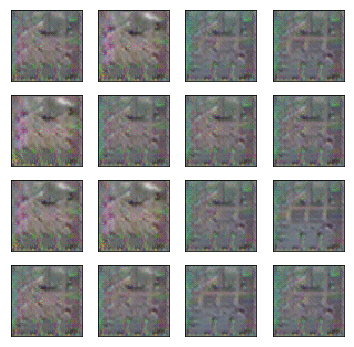

[39/40][701/782] Loss_D: 0.0039 Loss_G: 6.7486 D(x): 1.0000 D(G(z)): 0.0039 / 0.0039
[39/40][702/782] Loss_D: 0.0008 Loss_G: 7.9971 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[39/40][703/782] Loss_D: 0.0001 Loss_G: 10.1191 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[39/40][704/782] Loss_D: 0.0001 Loss_G: 9.8917 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[39/40][705/782] Loss_D: 0.0010 Loss_G: 7.4879 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[39/40][706/782] Loss_D: 0.0011 Loss_G: 9.5507 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[39/40][707/782] Loss_D: 0.0006 Loss_G: 9.1416 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[39/40][708/782] Loss_D: 0.0043 Loss_G: 6.6727 D(x): 0.9984 D(G(z)): 0.0027 / 0.0027
[39/40][709/782] Loss_D: 0.0003 Loss_G: 9.9834 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[39/40][710/782] Loss_D: 0.0001 Loss_G: 10.2500 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[39/40][711/782] Loss_D: 0.0004 Loss_G: 8.1179 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[39/40][712/782] Loss_D: 0.0009 Loss_G: 7.5218 D(x): 1.0000 D(G

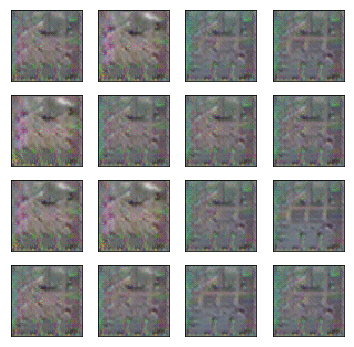

In [8]:
# create figure for plotting
num_test_samples = 16
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

def display_samples(fake_images):
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        
        img = fake_images[k].data.cpu() / 2 + 0.5
        npimg = img.numpy()
        
        ax[i,j].cla()
        ax[i,j].imshow(np.transpose(npimg, (1, 2, 0)), cmap='Greys')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())


display_every = 100

for epoch in range(nepochs):
    
    i = 0
    
    for data in dataloader:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        D.zero_grad()
        real_images, _ = data
        batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        ones_label = Variable(torch.ones(batch_size).float().cuda())

        output = D(real_images)
        D_real_loss = criterion(output, ones_label)
        D_real_loss.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = G(noisev)
        zeros_label = Variable(torch.zeros(batch_size).float().cuda())
        output = D(fake.detach())
        D_fake_loss = criterion(output, zeros_label)
        D_fake_loss.backward()
        D_G_z1 = output.data.mean()
        D_loss = D_real_loss + D_fake_loss
        D_optimizer.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        ones_label = Variable(torch.ones(batch_size).float().cuda())
        D_out = D(fake)
        G_loss = criterion(D_out, ones_label)
        G_loss.backward()
        D_G_z2 = output.data.mean()
        G_optimizer.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, nepochs, i, len(dataloader),
                 D_loss.data[0], G_loss.data[0], D_x, D_G_z1, D_G_z2))
        
        
        if i % display_every == 0:
            # DISPLAY GRID OF SAMPLES
            test_images = G(fixed_noise)
            display_samples(test_images)
        
        i += 1